In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, plot_roc_curve, roc_auc_score

from sklearn.inspection import permutation_importance

In [2]:
# set options to make data easier to view in Jupyter Notebook
pd.set_option("display.max_columns", 100)

# print numbers in pd.DataFrame (instead of scientific notation)
pd.set_option('display.precision', 12)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# set random seed to ensure reproducible results
np.random.seed(42)

# Prepare data for modeling

In [3]:
initial_features_df = pd.read_csv('../data/training_set_features.csv')
initial_labels_df = pd.read_csv('../data/training_set_labels.csv')

## Manually impute missing values in select columns

Manually handling NaNs in `health_insurance`, `employment_industry`, and `employment_occupation` columns

The [Interview questions](https://ftp.cdc.gov/pub/health_Statistics/nchs/Dataset_Documentation/NIS/nhfs/NHFSPUF_QUEX.PDF) offer "don't know" and "refused to answer" choices. I assume that the missing values likely reflect these choices.

I recoded the numeric values into a new string column, which can be go through OHE.

In [4]:
# replace NaNs with 'ins_refused' (assuming that these were "don't know" or "refused" options)
map_dict = {0: 'ins_no', 1: 'ins_yes', np.nan: 'ins_refused'}
initial_features_df['health_insurance_cat'] = initial_features_df['health_insurance'].map(map_dict)

In [5]:
# First replace NaN with 'ind_nowork' for non-employed
filt = (initial_features_df['employment_industry'].isna()) & (initial_features_df['employment_status'].isin(['Not in Labor Force', 'Unemployed']))
initial_features_df['employment_industry'].loc[filt] = 'ind_nowork'

# Then replace remaining NaNs with 'ind_refused' (again assuming that remaining NaN were don't know or refused options)
initial_features_df['employment_industry'].fillna('ind_refused')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0         ind_nowork
1           pxcmvdjn
2           rucpziij
3         ind_nowork
4           wxleyezf
            ...     
26702     ind_nowork
26703       fcxhlnwr
26704    ind_refused
26705       fcxhlnwr
26706     ind_nowork
Name: employment_industry, Length: 26707, dtype: object

In [6]:
# First replace NaN with 'occ_nowork' for non-employed
filt = (initial_features_df['employment_occupation'].isna()) & (initial_features_df['employment_status'].isin(['Not in Labor Force', 'Unemployed']))
initial_features_df['employment_occupation'].loc[filt] = 'occ_nowork'

# Then replace remaining NaNs with 'occ_refused' (again assuming that remaining NaN were don't know or refused options)
initial_features_df['employment_occupation'].fillna('occ_refused')

0         occ_nowork
1           xgwztkwe
2           xtkaffoo
3         occ_nowork
4           emcorrxb
            ...     
26702     occ_nowork
26703       cmhcxjea
26704    occ_refused
26705       haliazsg
26706     occ_nowork
Name: employment_occupation, Length: 26707, dtype: object

## Drop columns 

Drop columns that won't be used in model:
- respondent_id: key / unique identifier for each survey response
- health_insurance: has been recoded into new column, so old column is dropped
- irrelevant columns: questions about H1N1 don't seem to be pertinent for model predicting seasonal flu vaccines 


In [7]:
# drop columns that are not useful for training model
# drop health_insurance because we recoded it into string values above
initial_features_df.drop(columns=[
    'respondent_id', 'health_insurance',
    'h1n1_concern', 'h1n1_knowledge', 'doctor_recc_h1n1', 
    'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc'
], inplace=True)

## Set up train-test split

In [8]:
X = initial_features_df.copy()
y = initial_labels_df['seasonal_vaccine']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Set up pipelines

In [9]:
def grab_numeric(df):
    return df.select_dtypes(include=np.number)

def grab_object(df):
    return df.select_dtypes(exclude=np.number)

In [11]:
GrabNumeric = FunctionTransformer(grab_numeric)
GrabObject = FunctionTransformer(grab_object)

In [12]:
# Numeric columns don't need OneHotEncoding (opinion and household vars are ordinal, other vars are binary)
subpipe_num = Pipeline(steps=[
    ('get_num', GrabNumeric),
    ('num_impute', SimpleImputer(strategy='most_frequent')),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps=[
    ('get_obj', GrabObject),
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ('ss', StandardScaler())
])

In [13]:
ct = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, X_train.columns),
    ('subpipe_cat', subpipe_cat, X_train.columns)
])

## Verify that ColumnTransformer works

- Namely, ensure that there are no NaN values left over
- Also, check min and max values (using describe)

In [15]:
tmp = pd.DataFrame(ct.fit_transform(X_train))

In [16]:
print(f"Number of nulls: {tmp.isna().sum().sum()}")
display(tmp.describe())

Number of nulls: 0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102
count,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,...,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00
mean,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.23,-1.63,-0.27,-2.16,-0.74,-0.71,-1.44,-0.66,-0.61,-0.29,-0.35,-2.82,-1.24,-0.83,-1.19,-0.57,-0.50,-0.41,-0.49,-0.51,-0.59,-0.53,-0.31,-0.87,-0.60,-0.29,-0.26,-0.26,-1.98,-1.22,-0.82,-1.35,-0.58,-0.33,-1.13,-0.88,-1.88,-0.53,-1.13,-0.79,-0.24,-0.29,-0.34,-0.21,-0.37,-0.35,-0.29,-0.44,-0.30,-0.35,...,-0.61,-0.18,-0.19,-0.11,-0.08,-0.32,-0.08,-1.00,-0.22,-0.10,-0.15,-0.07,-0.10,-0.06,-0.20,-0.02,-0.14,-0.11,-0.14,-0.09,-0.27,-0.18,-0.14,-0.11,-0.12,-0.22,-0.08,-0.09,-0.22,-0.11,-0.17,-0.09,-0.14,-0.25,-1.01,-0.11,-0.06,-0.15,-0.10,-0.12,-0.12,-0.13,-0.12,-0.21,-0.14,-0.27,-0.10,-0.26,-0.92,-0.95
25%,-0.23,-1.63,-0.27,0.46,-0.74,-0.71,-1.44,-0.66,-0.61,-0.29,-0.35,-0.03,-0.51,-0.83,-1.19,-0.57,-0.50,-0.41,-0.49,-0.51,-0.59,-0.53,-0.31,-0.87,-0.60,-0.29,-0.26,-0.26,0.51,-1.22,-0.82,-1.35,-0.58,-0.33,-1.13,-0.88,0.53,-0.53,-1.13,-0.79,-0.24,-0.29,-0.34,-0.21,-0.37,-0.35,-0.29,-0.44,-0.30,-0.35,...,-0.61,-0.18,-0.19,-0.11,-0.08,-0.32,-0.08,-1.00,-0.22,-0.10,-0.15,-0.07,-0.10,-0.06,-0.20,-0.02,-0.14,-0.11,-0.14,-0.09,-0.27,-0.18,-0.14,-0.11,-0.12,-0.22,-0.08,-0.09,-0.22,-0.11,-0.17,-0.09,-0.14,-0.25,-1.01,-0.11,-0.06,-0.15,-0.10,-0.12,-0.12,-0.13,-0.12,-0.21,-0.14,-0.27,-0.10,-0.26,-0.92,-0.95
50%,-0.23,0.61,-0.27,0.46,-0.74,-0.71,0.69,-0.66,-0.61,-0.29,-0.35,-0.03,-0.51,-0.07,0.15,-0.57,-0.50,-0.41,-0.49,-0.51,-0.59,-0.53,-0.31,-0.87,-0.60,-0.29,-0.26,-0.26,0.51,0.82,-0.82,0.74,-0.58,-0.33,0.88,-0.88,0.53,-0.53,0.88,-0.79,-0.24,-0.29,-0.34,-0.21,-0.37,-0.35,-0.29,-0.44,-0.30,-0.35,...,-0.61,-0.18,-0.19,-0.11,-0.08,-0.32,-0.08,-1.00,-0.22,-0.10,-0.15,-0.07,-0.10,-0.06,-0.20,-0.02,-0.14,-0.11,-0.14,-0.09,-0.27,-0.18,-0.14,-0.11,-0.12,-0.22,-0.08,-0.09,-0.22,-0.11,-0.17,-0.09,-0.14,-0.25,0.99,-0.11

# Prepare to run models

In [17]:
# initialize lists to store model outputs
models = []
results = []
names = []
scoring="roc_auc"

In [18]:
### This class came from Lecture 51
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True, scoring="accuracy"):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds, scoring=scoring)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} {scoring}
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

# DummyClassifier model

In [19]:
dummy_model_pipe = Pipeline(steps=[
    ('ct',ct),
    ('dum_class', DummyClassifier(strategy='most_frequent', ))
])
dummy_cv = ModelWithCV(dummy_model_pipe, model_name='dummy_model_pipe', X=X_train, y=y_train, scoring=scoring)

CV Results for `dummy_model_pipe` model:
            0.50000 ± 0.00000 roc_auc
        


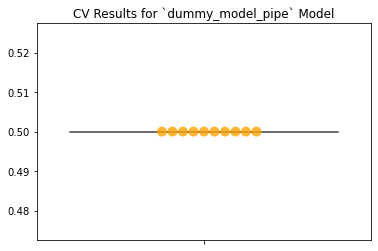

In [20]:
dummy_cv.print_cv_summary()
fig, ax = plt.subplots()

dummy_cv.plot_cv(ax=ax);

# Random Forest Classifier

In [21]:
rfc = RandomForestClassifier()

rfc_model_pipe = Pipeline([
    ('ct', ct),
    ('rfc', rfc)
])

In [22]:
rfc_defaults_cv = ModelWithCV(rfc_model_pipe, model_name='rfc_defaults_model_pipe', X=X_train, y=y_train, scoring=scoring)

CV Results for `rfc_defaults_model_pipe` model:
            0.84695 ± 0.01094 roc_auc
        


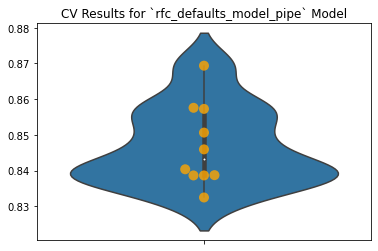

In [23]:
rfc_defaults_cv.print_cv_summary()

fig, ax = plt.subplots()
rfc_defaults_cv.plot_cv(ax=ax);

## GridSearchCV on Random Forest Classifier

In [24]:
params = {
    'rfc__n_estimators': [500, 750, 1000]
    ,'rfc__max_depth': [5, 15, 25]
    ,'rfc__max_features': [5, 15, 25]
    ,'rfc__min_samples_leaf': [1, 3, 5]
    ,'rfc__min_samples_split': [4, 8, 12]
}

In [25]:
%%time
rfc_gs_cv1 = GridSearchCV(estimator=rfc_model_pipe, scoring=scoring, param_grid=params, cv=5, n_jobs=-2)
rfc_gs_cv1.fit(X_train,y_train)

CPU times: user 42.9 s, sys: 1.18 s, total: 44.1 s
Wall time: 1h 6min 7s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7fb64e09f4c0>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'be

In [26]:
rfc_gs_cv1.best_params_

{'rfc__max_depth': 15,
 'rfc__max_features': 15,
 'rfc__min_samples_leaf': 3,
 'rfc__min_samples_split': 12,
 'rfc__n_estimators': 1000}

In [27]:
rfc_gs_cv1.best_score_

0.8548741229300992

In [28]:
import pickle
# save the model to disk
filename = '/Users/gburgess/Documents/Flatiron/projects/project3/Predicting_Vaccinations/data/rfc_gs_cv1_model.sav'
pickle.dump(rfc_gs_cv1, open(filename, 'wb'))

### Improve RandomForest hyperparameters with second GridSearchCV
We have a set of good hyperparameters from the first grid search. Now, starting with those results, we can narrow down the grid a bit more to improve the model some.

In [56]:
params = {
     'rfc__n_estimators': [800, 1000, 1200]
     ,'rfc__max_depth': [10, 15, 20]
     ,'rfc__max_features': [10, 15, 20]
     ,'rfc__min_samples_leaf': [2, 3, 4]
     ,'rfc__min_samples_split': [10, 12, 15, 20]
}

In [57]:
%%time
rfc_gs_cv2 = GridSearchCV(estimator=rfc_model_pipe, scoring=scoring, param_grid=params, cv=5, n_jobs=-2)
rfc_gs_cv2.fit(X_train,y_train)

CPU times: user 47.1 s, sys: 1.83 s, total: 48.9 s
Wall time: 2h 5min 54s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7fb64e09f4c0>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'be

In [58]:
rfc_gs_cv2.best_params_

{'rfc__max_depth': 15,
 'rfc__max_features': 15,
 'rfc__min_samples_leaf': 2,
 'rfc__min_samples_split': 20,
 'rfc__n_estimators': 800}

In [59]:
rfc_gs_cv2.best_score_

0.855200364622207

In [60]:
# save the model to disk
filename = '/Users/gburgess/Documents/Flatiron/projects/project3/Predicting_Vaccinations/data/rfc_gs_cv2_model.sav'
pickle.dump(rfc_gs_cv2, open(filename, 'wb'))

## Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

In [35]:
logreg = LogisticRegression()

logreg_model_pipe = Pipeline([
    ('ct', ct),
    ('logreg', logreg)
])

In [36]:
logreg_defaults_cv = ModelWithCV(
    logreg_model_pipe, 
    model_name='logreg_defaults_model_pipe', 
    X=X_train, y=y_train, 
    scoring=scoring
)

CV Results for `logreg_defaults_model_pipe` model:
            0.85285 ± 0.01022 roc_auc
        


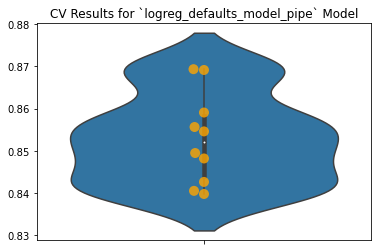

In [37]:
logreg_defaults_cv.print_cv_summary()

fig, ax = plt.subplots()
logreg_defaults_cv.plot_cv(ax=ax);

## GridSearchCV on Logistic Regression

In [38]:
params = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet']
    ,'logreg__C': [100, 10, 1.0, 0.1, 0.01]
    ,'logreg__solver': ['saga']
    ,'logreg__max_iter': [500, 1000]
}

In [39]:
%%time
logreg_gs_cv1 = GridSearchCV(estimator=logreg_model_pipe, scoring=scoring, param_grid=params, cv=5, n_jobs=-2)
logreg_gs_cv1.fit(X_train,y_train)

CPU times: user 5.41 s, sys: 233 ms, total: 5.64 s
Wall time: 1min 14s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7fb64e09f4c0>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'be

In [40]:
logreg_gs_cv1.best_params_

{'logreg__C': 0.1,
 'logreg__max_iter': 1000,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga'}

In [41]:
logreg_gs_cv1.best_score_

0.8529817125170286

In [42]:
import pickle
# save the model to disk
filename = '/Users/gburgess/Documents/Flatiron/projects/project3/Predicting_Vaccinations/data/logreg_gs_cv1_model.sav'
pickle.dump(logreg_gs_cv1, open(filename, 'wb'))

### Improve LogisticRegression hyperparameters with second GridSearchCV
We have a set of good hyperparameters from the first grid search. Now, starting with those results, we can narrow down the grid a bit more to improve the model some.

In [61]:
params = {
    'logreg__penalty': ['l1']
    ,'logreg__C': [0.5, 0.1, 0.05]
    ,'logreg__solver': ['saga', 'liblinear']
    ,'logreg__max_iter': [750, 1000, 1250]
}

In [62]:
%%time
logreg_gs_cv2 = GridSearchCV(estimator=logreg_model_pipe, scoring=scoring, param_grid=params, cv=5, n_jobs=-2)
logreg_gs_cv2.fit(X_train,y_train)

CPU times: user 3.72 s, sys: 179 ms, total: 3.9 s
Wall time: 57.7 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('get_num',
                                                                                          FunctionTransformer(func=<function grab_numeric at 0x7fb64e09f4c0>)),
                                                                                         ('num_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'be

In [63]:
logreg_gs_cv2.best_params_

{'logreg__C': 0.05,
 'logreg__max_iter': 1250,
 'logreg__penalty': 'l1',
 'logreg__solver': 'saga'}

In [64]:
logreg_gs_cv2.best_score_

0.8531190077567136

## Final Model: Random Forest Classifier

In [65]:
final_model = RandomForestClassifier(
    max_depth=15, 
    max_features=15,
    min_samples_leaf=2,
    min_samples_split=20, 
    n_estimators=800
)

final_model_pipe = Pipeline([
    ('ct', ct),
    ('final_model', final_model)
])

In [66]:
final_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('get_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x7fb64e09f4c0>)),
                                                                  ('num_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  Index(['behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'b...
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 

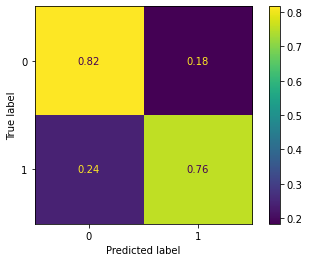

In [98]:
plot_confusion_matrix(final_model_pipe, X_test, y_test, normalize='true');
plt.savefig('../images/confusion_matrix.jpg', transparent = False, bbox_inches="tight")

In [69]:
y_hat = final_model_pipe.predict(X_test)
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.76 

Our final model's precision on the test set is 0.77 

Our final model's f1-score on the test is 0.77.



Our final model's ROC-AUC score is: 0.859


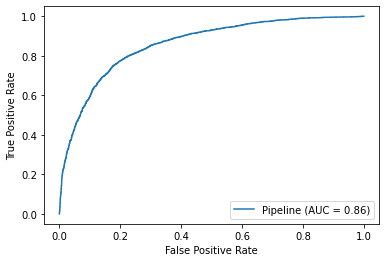

In [70]:
plot_roc_curve(final_model_pipe, X_test, y_test);
y_score = final_model_pipe.predict_proba(X_test)[:,1]
print(f"Our final model's ROC-AUC score is: {round(roc_auc_score(y_test, y_score), 3)}")

In [77]:
column_list1 = list(grab_numeric(X).columns)
column_list2 = list(
    final_model_pipe.named_steps['ct'].named_transformers_['subpipe_cat']['ohe'].get_feature_names()
)

final_column_list = column_list1 + column_list2
final_column_ndarray = np.array(final_column_list)

In [87]:
list ( zip(range(0,len(grab_object(X).columns)) ,  grab_object(X).columns)) 

[(0, 'age_group'),
 (1, 'education'),
 (2, 'race'),
 (3, 'sex'),
 (4, 'income_poverty'),
 (5, 'marital_status'),
 (6, 'rent_or_own'),
 (7, 'employment_status'),
 (8, 'hhs_geo_region'),
 (9, 'census_msa'),
 (10, 'employment_industry'),
 (11, 'employment_occupation'),
 (12, 'health_insurance_cat')]

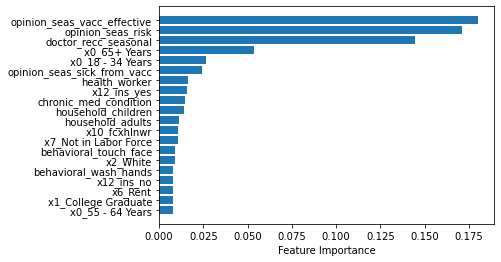

In [96]:
#https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285

final_model_FIs = final_model_pipe.named_steps['final_model'].feature_importances_
final_model_FIs_sort = final_model_pipe.named_steps['final_model'].feature_importances_.argsort()

num_elements = 20
ending_value = len(final_model_FIs)
starting_value = ending_value - num_elements

plt.barh(
    final_column_ndarray[ final_model_FIs_sort[starting_value:ending_value] ], 
    final_model_FIs[ final_model_FIs_sort[starting_value:ending_value] ]
)
plt.xlabel("Feature Importance");
plt.savefig('../images/feature_importance.jpg', transparent = False, bbox_inches="tight");

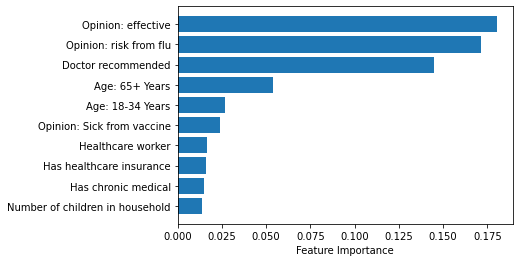

In [94]:
manual_list = ["Number of children in household", "Has chronic medical", "Has healthcare insurance", 
               "Healthcare worker", "Opinion: Sick from vaccine", "Age: 18-34 Years", 
               "Age: 65+ Years", "Doctor recommended",  "Opinion: risk from flu", "Opinion: effective"]

num_elements = 10
ending_value = len(final_model_FIs)
starting_value = ending_value - num_elements

plt.barh(
    manual_list, 
    final_model_FIs[ final_model_FIs_sort[starting_value:ending_value] ]
)
plt.xlabel("Feature Importance");
plt.savefig('../images/feature_importance_manual.jpg', transparent = False, bbox_inches="tight");